In [1]:
from src.data.dataset import DiskPlanet_singleStar_massesAndCount as DiskPlanetDataset
from src.data import data
from torch.utils.data.dataloader import DataLoader
import numpy as np
from src.model.models import NeuralNetv0
import torch
import matplotlib.pyplot as plt
import os

In [2]:
from sklearn.model_selection import train_test_split
# read dataset
#data_path = "/home/yannh/Documents/uni/phd/classes/pai/costum_project/dataset/raw_standardized_with_solar_mass"
data_path = "/home/yannh/Documents/uni/phd/classes/pai/costum_project/dataset/raw_standardized/J20_1MS.csv"

df = data.get_dataframe_single_file(data_path)

df_disk = data.get_disk_dataframe(df)


count = data.get_planet_counts(df)
masses = data.get_total_planets_mass(df)
df_label = data.join_dataframe(count, masses)
#df_label = count

# Split the data into training, validation, and test sets
train_data, val_test_data, train_label, val_test_label = train_test_split(df_disk, df_label, test_size=0.33)
val_data, test_data, val_label, test_label = train_test_split(val_test_data, val_test_label, test_size=0.33)

In [3]:
print(count)
print(masses)

       Number of planets
0                     18
1                     17
2                     17
3                     20
4                     18
...                  ...
14494                 14
14495                 20
14496                 17
14497                  7
14498                 20

[14499 rows x 1 columns]
       Total planets mass (Mearth)
0                        26.372119
1                         3.912124
2                       199.659274
3                         0.992856
4                        10.671086
...                            ...
14494                   562.782955
14495                     3.098590
14496                    98.198614
14497                   889.044633
14498                     1.235613

[14499 rows x 1 columns]


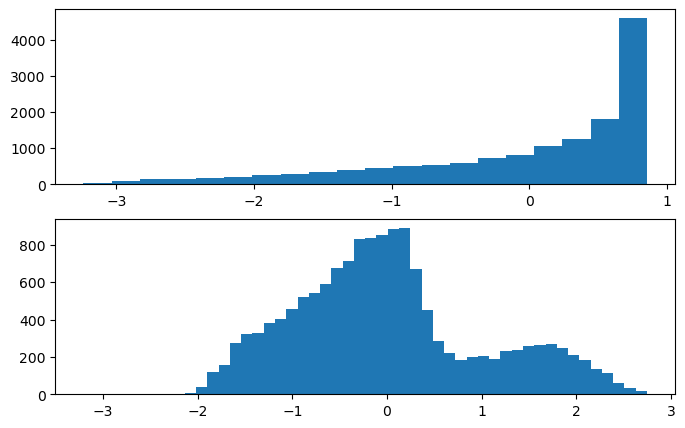

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5))
count_m = count.mean()
count_std = count.std()
count_log = count

ax[0].hist((count_log-count_log.mean())/count_log.std(), bins=20)

masses_log = np.log10(masses)
ax[1].hist((masses_log - masses_log.mean())/masses_log.std(), bins=50)

plt.show()

In [5]:
train_dataset = DiskPlanetDataset(train_data, train_label).process()
test_dataset = DiskPlanetDataset(test_data, test_label).process()
val_dataset = DiskPlanetDataset(val_data, val_label).process()

train_mean = train_dataset.disk_data.mean(axis=0)
train_std = train_dataset.disk_data.std(axis=0)

train_dataset.normalize(train_mean, train_std).to_numpy()
test_dataset.normalize(train_mean, train_std).to_numpy()
val_dataset.normalize(train_mean, train_std).to_numpy()



       Number of planets  Total planets mass (Mearth)
6212                  12                  1587.722302
1484                  19                    44.109529
7459                   3                  2098.429867
13848                 12                   562.330170
2036                  20                     6.264041
...                  ...                          ...
12692                 15                   350.079955
12429                 20                     1.331573
14030                 15                    49.061240
10189                 19                    13.358378
104                   19                     8.252604

[9714 rows x 2 columns]


Epoch 0 loss: 31.490392801008728
Epoch 10 loss: 2.592442034890777
Epoch 20 loss: 2.5360540951553143
Epoch 30 loss: 2.542145156546643
Epoch 40 loss: 2.515055258807383
Epoch 50 loss: 2.48401808032864
Epoch 60 loss: 2.496273941115329
Epoch 70 loss: 2.4759081711894586
Epoch 80 loss: 2.464546264002198
Epoch 90 loss: 2.471017949283123
Epoch 100 loss: 2.455042737879251


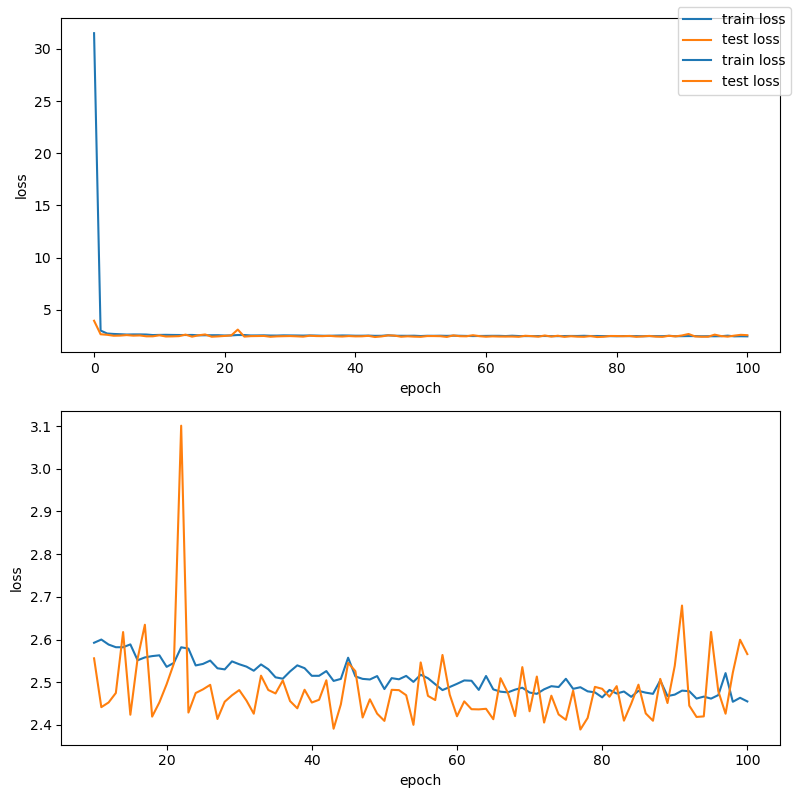

In [23]:





# train_dataset = DiskPlanet(train_data, train_label).normalize(train_mean, train_std).to_numpy()
# test_dataset = DiskPlanet(test_data, test_label).normalize(train_mean, train_std).to_numpy()

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)




n_epochs = 100

n_epochs+=1
train_loss_values = np.empty(n_epochs)
test_loss_values = np.empty(n_epochs)



input_dim = df_disk.shape[1]
output_dim = df_label.shape[1]
hidden_dim = 100

    
model = NeuralNetv0(input_dim, hidden_dim, output_dim)
learning_rate = 1e-3
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i_epoch, epoch in enumerate(range(n_epochs)):
    running_loss = 0
    model.train(True)
    for i_data, (inputs, labels) in enumerate(train_loader):

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()#/batch_size pytorch return the mean by default
        loss.backward()
        optimizer.step()
        
    train_loss_values[i_epoch] = running_loss/len(train_loader)
    
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for i_data, (inputs, labels) in enumerate(test_loader):
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
        test_loss_values[i_epoch] = running_loss/len(test_loader)
            
        
            
    if i_epoch % (n_epochs//10) == 0:
        print(f"Epoch {epoch} loss: {train_loss_values[i_epoch]}")



fig ,ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(np.arange(n_epochs), train_loss_values, label="train loss")
ax[0].plot(np.arange(n_epochs), test_loss_values, label="test loss")
ax[1].plot(np.arange(n_epochs//10, n_epochs), train_loss_values[n_epochs//10:])
ax[1].plot(np.arange(n_epochs//10, n_epochs), test_loss_values[n_epochs//10:])
ax[0].set(
    xlabel="epoch",
    ylabel="loss"
)
ax[1].set(
    xlabel="epoch",
    ylabel="loss"
)
fig.legend()
name_loss_plot = f"loss_batchsize{batch_size}_lr{learning_rate:1.0e}.png"
model_name = model.get_name()

plot_path = f"./plots/{model_name}"
model_path = f"./models/{model_name}/batchsize{batch_size}_lr{learning_rate:1.0e}/"
model_save_name = f"{model_name}_epoch{epoch}.pt"
plot_file = os.path.join(plot_path, name_loss_plot)

plt.tight_layout()
os.makedirs(plot_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
plt.savefig(plot_file, dpi=90)
plt.show()
#plt.close()

model_file = os.path.join(model_path, model_save_name)
torch.save({
    "epoch":epoch,
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss":test_loss_values[-1]
}, model_file)




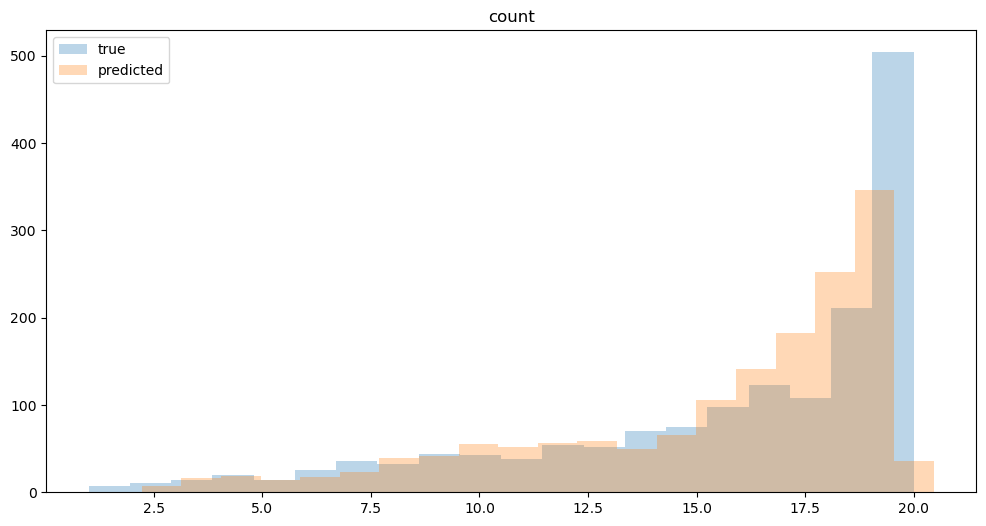

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


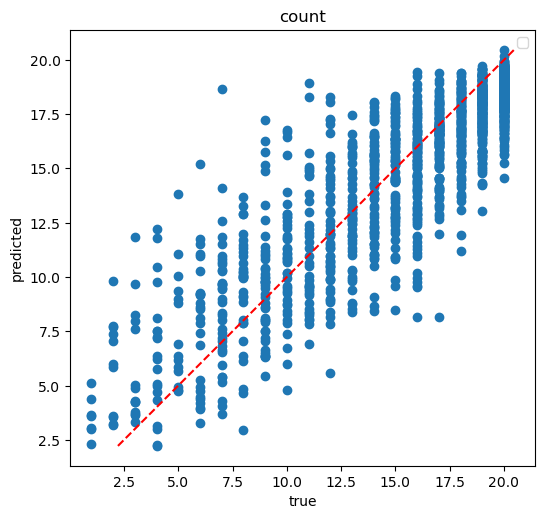

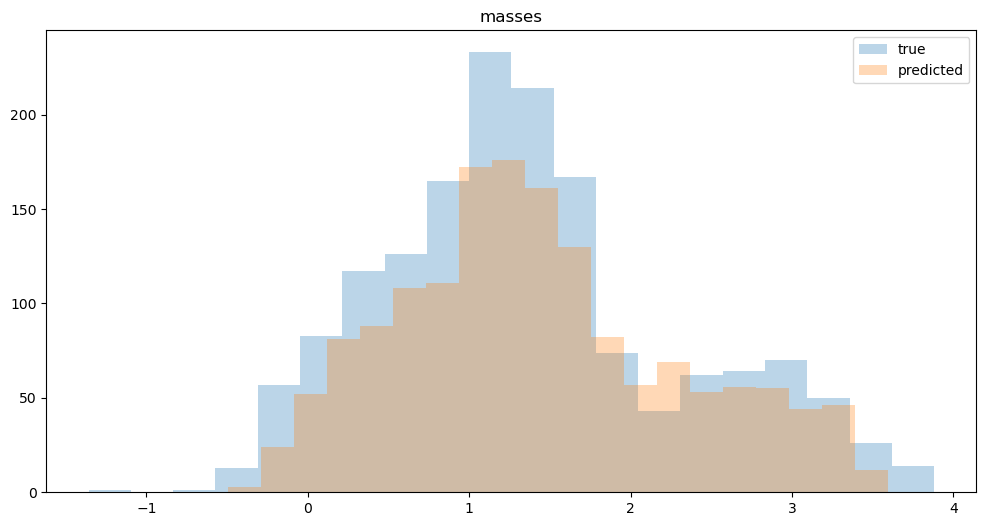

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


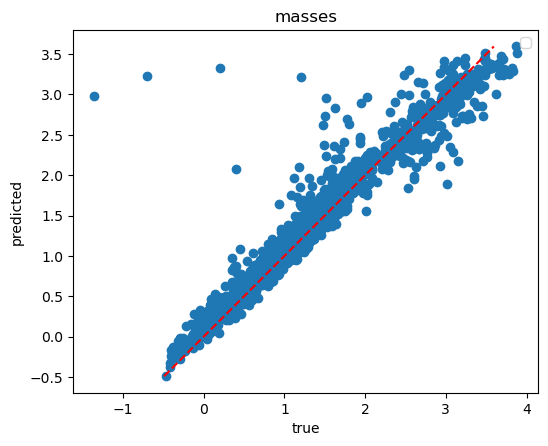

In [24]:
test_label_np = test_label.to_numpy()
outputs_array = np.empty(test_label_np.shape)
labels_array = np.empty(test_label_np.shape)



with torch.no_grad():
    prev_index = 0
    for i_data, (inputs, labels) in enumerate(test_loader):
        
        outputs = model(inputs).numpy()
        labels = labels.numpy()
        
        outputs_array[prev_index:prev_index+outputs.shape[0]] = outputs
        labels_array[prev_index:prev_index+outputs.shape[0]] = labels
        prev_index += outputs.shape[0]


names = ["count", "masses"]
for dim in range(test_label_np.shape[1]):        
    fig, ax = plt.subplots(1,1, figsize=(12, 6))
    ax.hist(labels_array[:, dim], alpha=0.3, label="true", bins=20)
    ax.hist(outputs_array[:, dim], alpha=0.3, label="predicted", bins=20)
    ax.set(title=f"{names[dim]}")
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(1,1, figsize=(6, 6))
    ax.scatter(labels_array[:, dim], outputs_array[:, dim])
    ax.set(xlabel="true", ylabel="predicted", title=f"{names[dim]}")
    ax.plot([min(outputs_array[:, dim]), max(outputs_array[:, dim])], [min(outputs_array[:, dim]), max(outputs_array[:, dim])], 'r--')
    ax.set_aspect('equal', 'box')
    plt.legend()
    plt.show()
    